# Week 4 Data Exploration Challenge — Welltory COVID-19 and Wearables Open Data Research Dataset  

**Overview:** Analysis of data collected via the Welltory app and connected devices during COVID.  
This dataset includes anonymized HRV (heart rate variability) and related metrics.  

## Cleaning Plan  
1. Convert measurement_datetime to datetime and drop invalid values.  
2. Drop duplicate rows using user_code and measurement_datetime as the key
3. Impute missing HRV metrics rmssd pnn50 with the median of the dataset values.  
4. Clip outliers using the 1st–99th percentile bounds to reduce sensor glitches without flattening the data too much. 
5. Note: A steps column was not present in this dataset, so step-related imputation and the hrv_per_step feature were skipped.  

## Features
- user_code: anonymized participant ID  
- measurement_datetime: when the reading was taken  
- bpm: beats per minute  
- rmssd: time domain HRV metric  
- pnn50: the %age of intervals >50ms  
- Other columns: additional HRV statistics such as sdnn, lf, hf, etc  

**Sampling context:** This is observational, anonymized data from Welltory users during COVID. Potential for sampling bias (health-motivated individuals more likely to be users, limited to people with access to wearable devices).  

## Transformations and New Feature  

- Extracted a new date and hour time based feature from measurement_datetime to enable time-based grouping and analysis.  

## Data Quality Discussion  

- Completeness: Gaps in HRV metrics rmssd and pnn50 were filled with the median values.  
- Consistency: Standardized datetimes and removed duplicate rows.  
- Accuracy: Outlier sensor spikes were reduced by clipping to the 1st through the 99th percentile range.  
- Integrity: Each user_code and measurement_datetime now represents a unique measurement.  
- Lineage: Public Welltory dataset, collected via app and wearable devices during COVID. Observational in nature, with likely sampling bias.  


In [1]:
#Imports and Setup

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

DATA_DIR = os.path.expanduser("~/Desktop/welltory-data")

csv_files = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
print("Found", len(csv_files), "CSV files")
print(csv_files[:15])  # preview first 15


Found 9 CSV files
['scales_description.csv', 'participants.csv', 'wearables.csv', 'blood_pressure.csv', 'surveys.csv', 'heart_rate.csv', 'weather.csv', 'hrv_measurements.csv', 'sleep.csv']


In [2]:
#Loading CV
CSV_FILE = "hrv_measurements.csv"  #file to analyze

fp = os.path.join(DATA_DIR, CSV_FILE)
df = pd.read_csv(fp)
print("Rows:", len(df), "Cols:", df.shape[1])
df.head()


Rows: 3245 Cols: 22


,user_code,rr_code,measurement_datetime,time_of_day,bpm,meanrr,mxdmn,sdnn,rmssd,pnn50,...,lf,hf,vlf,lfhf,total_power,how_feel,how_mood,how_sleep,tags,rr_data
0,007b8190cf,10489a6aea,2020-04-21 21:23:08,morning,75,795.90,0.12,45.802,54.174,15.15,...,508.0,1076.0,267.0,0.472,1851.0,0,-1,NaN,COVID-19; Workout; Sex; Hobby; Studying; Sleep...,"819,1008,831,847,785,778,866,839,801,793,846,8..."
1,007b8190cf,9610d4d4dc,2020-04-26 11:19:25,morning,70,858.00,0.11,32.889,33.022,16.16,...,409.0,310.0,176.0,1.319,895.0,0,0,0.0,NaN,"888,775,811,883,890,894,894,899,893,889,890,83..."
2,013f6d3e5b,f3de056155,2020-05-15 04:14:21,night,83,724.10,0.17,54.811,65.987,17.17,...,432.0,881.0,194.0,0.490,1507.0,-1,-2,NaN,COVID-19; Fast/Diet; Hungry; Tired; Fever; I c...,"694,832,642,801,751,716,737,742,773,760,701,73..."
3,013f6d3e5b,b04489e32f,2020-05-19 03:06:02,night,75,802.64,0.20,72.223,70.039,22.22,...,814.0,1487.0,1719.0,0.547,4020.0,0,0,NaN,NaN,"821,817,771,805,833,788,747,724,792,825,775,75..."
4,01bad5a519,ac52c706c6,2019-12-31 09:07:43,morning,78,768.07,0.10,29.650,21.196,4.04,...,489.0,128.0,96.0,3.820,713.0,0,0,0.0,NaN,"741,740,734,737,740,731,751,747,745,728,747,76..."


In [3]:
#Initial visibility

print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())

missing = df.isna().sum().sort_values(ascending=False)
print("Missing values:")
print(missing.head(10))

Shape: (3245, 22)
user_code                object
rr_code                  object
measurement_datetime     object
time_of_day              object
bpm                       int64
meanrr                  float64
mxdmn                   float64
sdnn                    float64
rmssd                   float64
pnn50                   float64
mode                    float64
amo                     float64
lf                      float64
hf                      float64
vlf                     float64
lfhf                    float64
total_power             float64
how_feel                  int64
how_mood                  int64
how_sleep               float64
tags                     object
rr_data                  object
dtype: object
               bpm       meanrr        mxdmn         sdnn        rmssd  \
count  3245.000000  3245.000000  3245.000000  3245.000000  3245.000000   
mean     73.257935   839.600366     0.184635    52.489218    52.814196   
std      12.201088   137.420367     0.1074

In [4]:
#print(df.columns)


In [5]:
#Data Cleaning
df["measurement_datetime"] = pd.to_datetime(df["measurement_datetime"], errors="coerce")
df = df.dropna(subset=["measurement_datetime"])


if "user_code" in df.columns:
    df = df.drop_duplicates(subset=["user_code","measurement_datetime"])

if "rmssd" in df.columns:
    df["rmssd"] = df["rmssd"].fillna(df["rmssd"].median())

if "pnn50" in df.columns:
    df["pnn50"] = df["pnn50"].fillna(df["pnn50"].median())

if "steps" in df.columns:
    df["steps"] = df["steps"].fillna(df["steps"].mean())

for col in ["rmssd","pnn50","steps","heart_rate","hr"]:
    if col in df.columns:
        low, high = df[col].quantile([0.01,0.99])
        df[col] = df[col].clip(lower=low, upper=high)

df.head()


,user_code,rr_code,measurement_datetime,time_of_day,bpm,meanrr,mxdmn,sdnn,rmssd,pnn50,...,lf,hf,vlf,lfhf,total_power,how_feel,how_mood,how_sleep,tags,rr_data
0,007b8190cf,10489a6aea,2020-04-21 21:23:08,morning,75,795.90,0.12,45.802,54.174,15.15,...,508.0,1076.0,267.0,0.472,1851.0,0,-1,NaN,COVID-19; Workout; Sex; Hobby; Studying; Sleep...,"819,1008,831,847,785,778,866,839,801,793,846,8..."
1,007b8190cf,9610d4d4dc,2020-04-26 11:19:25,morning,70,858.00,0.11,32.889,33.022,16.16,...,409.0,310.0,176.0,1.319,895.0,0,0,0.0,NaN,"888,775,811,883,890,894,894,899,893,889,890,83..."
2,013f6d3e5b,f3de056155,2020-05-15 04:14:21,night,83,724.10,0.17,54.811,65.987,17.17,...,432.0,881.0,194.0,0.490,1507.0,-1,-2,NaN,COVID-19; Fast/Diet; Hungry; Tired; Fever; I c...,"694,832,642,801,751,716,737,742,773,760,701,73..."
3,013f6d3e5b,b04489e32f,2020-05-19 03:06:02,night,75,802.64,0.20,72.223,70.039,22.22,...,814.0,1487.0,1719.0,0.547,4020.0,0,0,NaN,NaN,"821,817,771,805,833,788,747,724,792,825,775,75..."
4,01bad5a519,ac52c706c6,2019-12-31 09:07:43,morning,78,768.07,0.10,29.650,21.196,4.04,...,489.0,128.0,96.0,3.820,713.0,0,0,0.0,NaN,"741,740,734,737,740,731,751,747,745,728,747,76..."


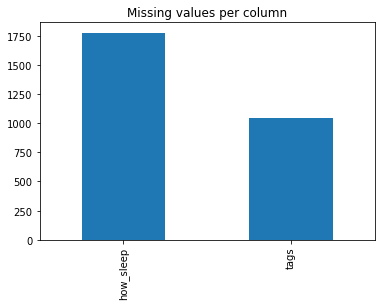

In [6]:
#Missing Values

mv = df.isna().sum()
mv[mv > 0].plot(kind="bar", title="Missing values per column")
plt.show()

In [7]:
#HRV per step ratio setup

df["date"] = df["measurement_datetime"].dt.date
df["hour"] = df["measurement_datetime"].dt.hour

if "rmssd" in df.columns and "steps" in df.columns:
    df["hrv_per_step"] = df["rmssd"] / (df["steps"] + 1)

agg_cols = [c for c in ["rmssd","steps","heart_rate","hr","hrv_per_step"] if c in df.columns]
daily = df.groupby("date")[agg_cols].mean().reset_index()
daily.head()

,date,rmssd
0,2019-12-31,42.747000
1,2020-01-01,60.812667
2,2020-01-02,93.866000
3,2020-01-03,48.776333
4,2020-01-04,69.181000


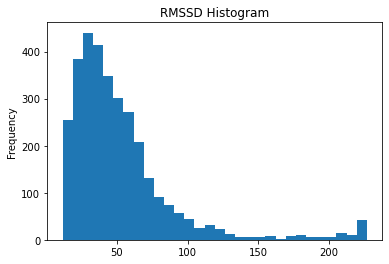

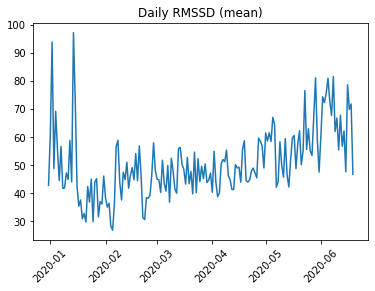

In [8]:
#Visualizing Results

if "rmssd" in df.columns:
    df["rmssd"].plot(kind="hist", bins=30, title="RMSSD Histogram")
    plt.show()

if "steps" in df.columns and "rmssd" in df.columns:
    df.plot(kind="scatter", x="steps", y="rmssd", title="Steps vs RMSSD")
    plt.show()

if "rmssd" in daily.columns:
    plt.plot(daily["date"], daily["rmssd"])
    plt.title("Daily RMSSD (mean)")
    plt.xticks(rotation=45)
    plt.show()

In [9]:
#Initial display setup and error message
try:
    display(df.info())
    display(df.describe())
    missing = df.isna().sum().sort_values(ascending=False)
    print("Top missing-value columns:")
    display(missing.head(10))
except NameError:
    print("NameError. Missing CSV load")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3245 entries, 0 to 3244
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_code             3245 non-null   object        
 1   rr_code               3245 non-null   object        
 2   measurement_datetime  3245 non-null   datetime64[ns]
 3   time_of_day           3245 non-null   object        
 4   bpm                   3245 non-null   int64         
 5   meanrr                3245 non-null   float64       
 6   mxdmn                 3245 non-null   float64       
 7   sdnn                  3245 non-null   float64       
 8   rmssd                 3245 non-null   float64       
 9   pnn50                 3245 non-null   float64       
 10  mode                  3245 non-null   float64       
 11  amo                   3245 non-null   float64       
 12  lf                    3245 non-null   float64       
 13  hf                

None

,bpm,meanrr,mxdmn,sdnn,rmssd,pnn50,mode,amo,lf,hf,vlf,lfhf,total_power,how_feel,how_mood,how_sleep,hour
count,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,1466.000000,3245.000000
mean,73.257935,839.600366,0.184635,52.489218,52.596206,20.587596,0.837465,46.788290,927.038213,1125.041294,578.229892,2.397769,2630.309399,-0.235439,-0.076733,-0.065484,12.862866
std,12.201088,137.420367,0.107456,29.369506,38.180999,18.489299,0.144769,16.418873,1455.424089,2490.540413,876.679652,5.750760,3912.247496,0.706262,0.655032,0.708656,6.161812
min,44.000000,477.730000,0.030000,9.515000,11.704360,0.000000,0.475000,12.000000,2.000000,4.000000,1.000000,0.032000,44.000000,-2.000000,-2.000000,-2.000000,0.000000
25%,65.000000,742.490000,0.110000,32.585000,28.985000,6.060000,0.725000,35.000000,151.000000,158.000000,116.000000,0.399000,620.000000,-1.000000,0.000000,0.000000,8.000000
50%,72.000000,829.100000,0.160000,46.919000,42.869000,16.160000,0.825000,45.000000,423.000000,380.000000,293.000000,0.862000,1387.000000,0.000000,0.000000,0.000000,11.000000
75%,81.000000,925.933000,0.220000,64.406000,62.485000,29.290000,0.925000,57.000000,1059.000000,993.000000,693.000000,1.966000,2906.000000,0.000000,0.000000,0.000000,19.000000
max,125.000000,1346.740000,0.790000,206.631000,226.640960,83.840000,1.325000,98.000000,15522.000000,33490.000000,18468.000000,105.625000,41118.000000,2.000000,2.000000,2.000000,23.000000


Top missing-value columns:


how_sleep      1779
tags           1044
user_code         0
rr_code           0
date              0
rr_data           0
how_mood          0
how_feel          0
total_power       0
lfhf              0
dtype: int64

## Conclusion  

This exploration shows how raw wearable datasets require careful cleaning before they can be meaningfully interpreted. By standardizing time fields, imputing missing HRV values, and clipping outliers, the dataset became consistent enough to visualize and summarize. Although some planned features could not be created due to missing activity data such as HRV each step, the process shows both the potential and the limitations of observational wearable data. Overall, it is clear that data preparation choices directly shape the quality of any insights and analytics
